# MHC II Analysis

In [89]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
import itertools
%matplotlib inline

In [90]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [91]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [92]:
data_path = '/data_volume/ifn_hbec/'
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig5/main/'

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [93]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [94]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [95]:
adata.shape

(69958, 36588)

### Setup memento

In [96]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [97]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [98]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1, filter_mean_thresh=0.04)

### Check some expresssion level over time

In [108]:
stim = 'gamma'
ct = ['ciliated']

In [109]:
subset = adata[adata.obs['cell_type'].isin(ct) & adata.obs.stim.isin(['control', stim])].copy().copy()
memento.create_groups(subset, label_columns=['time', 'donor'])
memento.compute_1d_moments(subset, min_perc_group=.9)
mean_df = memento.get_1d_moments(subset, groupby='time')[0][['gene'] + ['time_' + str(i) for i in [0, 3, 6, 9, 24, 48]]]
var_df = memento.get_1d_moments(subset, groupby='time')[1][['gene'] + ['time_' + str(i) for i in [0, 3, 6, 9, 24, 48]]]

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log


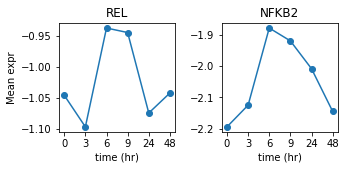

In [110]:
d = mean_df.query('gene.isin(["REL", "NFKB2"])', engine='python')
plt.figure(figsize=(5,2))
plt.subplots_adjust(wspace=0.4)
locs = [1, 2]
cs = [0, 2]
num=0
for idx, row in d.iterrows():
    plt.subplot(1,2,locs[num])
    plt.plot(row.values[1:], '-o')
    plt.title(row['gene'])
    plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
    if num == 0:
        plt.ylabel('Mean expr')
    plt.xlabel('time (hr)')
    num +=1

# plt.savefig(fig_path + 'mhc_aux_mean.pdf', bbox_inches='tight')


In [111]:
class2_genes = [ 'HLA-DRA',
 'HLA-DRB1',
 'HLA-DQB1',
 'HLA-DMB',
 'HLA-DMA',
 'HLA-DPA1',
 'HLA-DPB1']
class1_genes = ["HLA-A", "HLA-B", "HLA-C", "B2M"]

Text(0.5, 0, 'time (hr)')

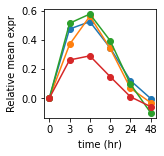

In [112]:
plt.figure(figsize=(2,2))
d = mean_df.query('gene.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python').values[:,1:]
d = d - d[:, 0].reshape(-1,1)
plt.plot(d.T, '-o'); plt.ylabel('Relative mean expr')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48']); plt.xlabel('time (hr)')

In [113]:
class2_genes = [ 'HLA-DRA',
 'HLA-DRB1',
 'HLA-DQB1',
 'HLA-DPA1',
 'HLA-DPB1']

Text(0.5, 0, 'time (hr)')

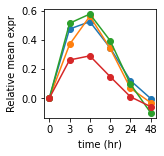

In [120]:
plt.figure(figsize=(2,2))
d = mean_df.query('gene in @class1_genes', engine='python').values[:,1:]
d = d - d[:, 0].reshape(-1,1)
plt.plot(d.T, '-o'); plt.ylabel('Relative mean expr')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48']); plt.xlabel('time (hr)')

Text(0.5, 0, 'time (hr)')

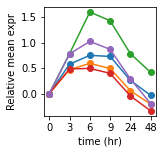

In [119]:
plt.figure(figsize=(2,2))
d = mean_df.query('gene in @class2_genes', engine='python').values[:,1:]
d = d - d[:, 0].reshape(-1,1)
plt.plot(d.T, '-o'); plt.ylabel('Relative mean expr')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48']); plt.xlabel('time (hr)')

Text(0.5, 0, 'time (hr)')

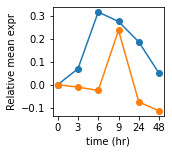

In [128]:
plt.figure(figsize=(2,2))
d = mean_df.query('gene.isin(["RELA", "NFKB2"])', engine='python').values[:,1:]
# d = d - d[:, 0].reshape(-1,1)
plt.plot(d.T, '-o'); plt.ylabel('Relative mean expr')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48']); plt.xlabel('time (hr)')

In [ ]:
mhc_genes

In [ ]:
plt.figure(figsize=(2,2))
d = mean_df.query('gene.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python').values[:,1:]
d = d - d[:, 0].reshape(-1,1)
plt.plot(d.T, '-o'); plt.ylabel('Relative mean expr')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48']); plt.xlabel('time (hr)')

### Correlation of MHC I transcripts to STAT1

In [18]:
canonical_isgs = pd.read_csv('alpha_beta_reactome.txt', header=None)[0].tolist()


In [19]:
cts = [['ciliated']]
tps = ['3', '6', '9', '24', '48']
stims = ['beta']


for ct in cts:
    for tp in tps:
        for stim in stims:
                            
            print('starting', ct, tp, stim)

            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin(['0',tp]), :].copy()
            time_converter={0:0, int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.9)
            
            m, v, count = memento.get_1d_moments(adata_stim)
            mhc_genes = m.query('gene.str.contains("HLA")', engine='python').gene.tolist()
            
            tf_list = ['STAT1']
            gene_list = adata_stim.var.index.tolist()
            
            isgs = list(set(canonical_isgs) & set(gene_list))
            
            target_list = list(set(isgs) | set(mhc_genes))
            
            memento.compute_2d_moments(adata_stim, list(itertools.product(tf_list,target_list)))

            moment_df = memento.get_2d_moments(adata_stim, groupby='time_step')
            moment_df.to_csv('/data_volume/ifn_hbec/tf_test/moments_{}_{}_{}_mhc1_20210329.csv'.format('-'.join(ct), stim, tp), index=False)

starting ['ciliated'] 3 beta


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


starting ['ciliated'] 6 beta


/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg/memento/main.py:594: RuntimeWarning: invalid value encountered in true_divide


starting ['ciliated'] 9 beta
starting ['ciliated'] 24 beta
starting ['ciliated'] 48 beta


In [20]:
stim = 'beta'
ct = ['ciliated']
for tp in ['3', '6', '9', '24', '48']:
    
    moments = pd.read_csv('/data_volume/ifn_hbec/tf_test/moments_{}_{}_{}_mhc1_20210329.csv'.format('-'.join(ct), stim, tp)).rename(columns={'time_step_0':'time_0', 'time_step_1':'time_'+tp})
    
    if tp == '3':
        moment_df = moments[['gene_1', 'gene_2', 'time_0', 'time_3']].copy()
        
    else:
        moment_df = moment_df.merge(moments[['gene_1', 'gene_2', 'time_{}'.format(tp)]].copy(), on=['gene_1', 'gene_2'], how='inner')

In [26]:
mhc_genes

['HHLA3',
 'HHLA2',
 'HLA-F',
 'HLA-A',
 'HLA-E',
 'HLA-C',
 'HLA-B',
 'HLA-DRA',
 'HLA-DRB1',
 'HLA-DQB1',
 'HLA-DMB',
 'HLA-DMA',
 'HLA-DPA1',
 'HLA-DPB1']

In [27]:
class2_genes = [ 'HLA-DRA',
 'HLA-DRB1',
 'HLA-DQB1',
 'HLA-DMB',
 'HLA-DMA',
 'HLA-DPA1',
 'HLA-DPB1']

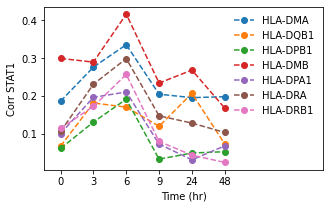

In [41]:
tf = 'STAT1'
# plt.subplot(1, 3, 2)
plt.figure(figsize=(5,3))
plt.plot(moment_df.query('gene_1 == "{}" & gene_2 in @class2_genes'.format(tf)).values[:, 2:].T, '--o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))
plt.xlim(-0.5, 8)
plt.legend(moment_df.query('gene_1 == "{}" & gene_2 in @class2_genes'.format(tf)).gene_2, frameon=False, ncol=1, loc='upper right')

In [22]:
moment_df.query('gene_2.str.contains("HLA")',engine='python')

,gene_1,gene_2,time_0,time_3,time_6,time_9,time_24,time_48
1,STAT1,HLA-DMA,0.186085,0.276302,0.335635,0.204530,0.195442,0.197912
4,STAT1,HLA-E,0.415575,0.547246,0.587484,0.544590,0.566349,0.526313
9,STAT1,HLA-DQB1,0.067106,0.181302,0.170235,0.119651,0.206668,0.072616
10,STAT1,HLA-A,0.184255,0.416530,0.406567,0.169951,0.140786,0.112371
11,STAT1,HHLA3,0.022620,0.094330,0.003656,-0.075182,0.036877,0.026201
12,STAT1,HLA-B,0.201227,0.420494,0.434898,0.246592,0.201684,0.156004
23,STAT1,HLA-DPB1,0.060931,0.130701,0.191342,0.032517,0.048804,0.052269
29,STAT1,HLA-DMB,0.299191,0.289529,0.416531,0.234043,0.268440,0.167772
34,STAT1,HLA-F,0.303196,0.464457,0.516259,0.421187,0.428796,0.360041
36,STAT1,HLA-DPA1,0.100393,0.196178,0.210389,0.072522,0.030815,0.067726


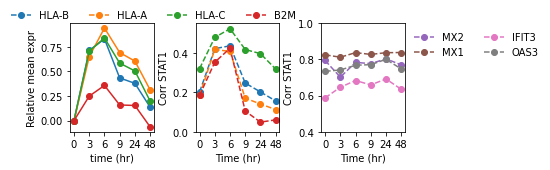

In [162]:
tf = 'STAT1'
plt.figure(figsize=(6,2))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 3, 1);

d = mean_df.query('gene.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python').values[:,1:]
d = d - d[:, 0].reshape(-1,1)
plt.plot(d.T, '-o'); plt.ylabel('Relative mean expr')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48']); plt.xlabel('time (hr)')

plt.subplot(1, 3, 2)
plt.plot(moment_df.query('gene_1 == "{}" & gene_2 in @mhc_genes'.format(tf)).values[:, 2:].T, '--o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))
plt.ylim(0, 0.55)
plt.legend(moment_df.query('gene_1 == "{}" & gene_2 in @mhc_genes'.format(tf)).gene_2, frameon=False, ncol=4, bbox_to_anchor=(1.3,1.2))


select_isgs = ['MX1','MX2', 'OAS3', 'IFIT3', 'IFI2']
plt.subplot(1, 3, 3)
for i in range(4):
    plt.plot(moment_df.query('gene_1 == "{}" & gene_2 in @select_isgs'.format(tf)).values[i, 2:].T, '--o', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][4+i])
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))
plt.ylim(0.4, 1);
plt.legend(moment_df.query('gene_1 == "{}" & gene_2 in @select_isgs'.format(tf)).gene_2, frameon=False, ncol=2, bbox_to_anchor=(1,1))

plt.savefig(fig_path + 'mhc_mean_corr.pdf', bbox_inches='tight')

In [88]:
moment_df

,gene_1,gene_2,time_0,time_3,time_6,time_9,time_24,time_48
0,STAT1,IRF2,0.209428,0.345655,0.351665,0.403791,0.328545,0.330277
1,STAT1,HLA-B,0.201227,0.420494,0.434898,0.246592,0.201684,0.156004
2,STAT1,IFITM1,0.725632,0.648829,0.722967,0.712443,0.752257,0.719679
3,STAT1,IFITM2,0.428704,0.519050,0.551876,0.540026,0.512139,0.507080
4,STAT1,SOCS1,0.511312,0.388728,0.363513,0.474186,0.473442,0.504350
5,STAT1,IFITM3,0.740275,0.668623,0.738930,0.742767,0.746072,0.721912
6,STAT1,IRF7,0.635426,0.643951,0.687727,0.646674,0.672363,0.638066
7,STAT1,IFI6,0.581431,0.598028,0.678681,0.584084,0.500680,0.451282
8,STAT1,EGR1,0.036578,0.133676,0.208113,0.177444,0.209361,0.185099
9,STAT1,OAS2,0.901655,0.889552,0.885935,0.894787,0.874481,0.850491


In [89]:
select_isgs = ['MX1', 'OAS3', 'IFIT3', 'IFI2']

In [90]:
moment_df.query('gene_1 == "{}" & gene_2 in @select_isgs'.format(tf))

,gene_1,gene_2,time_0,time_3,time_6,time_9,time_24,time_48
14,STAT1,MX1,0.824872,0.811559,0.836918,0.827033,0.836616,0.837403
24,STAT1,IFIT3,0.587385,0.645985,0.683055,0.658808,0.691653,0.634757
50,STAT1,OAS3,0.733548,0.741300,0.767259,0.770594,0.799914,0.747048


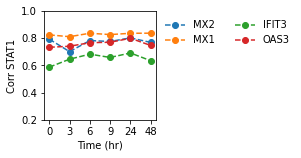

In [104]:
tf = 'STAT1'
select_isgs = ['MX1','MX2', 'OAS3', 'IFIT3', 'IFI2']
plt.figure(figsize=(2,2))
plt.plot(moment_df.query('gene_1 == "{}" & gene_2 in @select_isgs'.format(tf)).values[:, 2:].T, '--o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))
plt.ylim(0.2, 1);
plt.legend(moment_df.query('gene_1 == "{}" & gene_2 in @select_isgs'.format(tf)).gene_2, frameon=False, ncol=2, bbox_to_anchor=(1,1))


# plt.savefig(fig_path + 'mhc_stat1_corr.pdf', bbox_inches='tight')

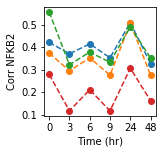

In [40]:
tf = 'NFKB2'
plt.figure(figsize=(2,2))
plt.plot(moment_df.query('gene_1 == "{}"'.format(tf)).values[:, 2:].T, '--o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))
plt.savefig(fig_path + 'mhc_corr_NFKB2.pdf', bbox_inches='tight')


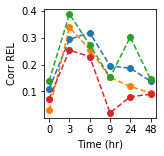

In [41]:
tf = 'REL'
plt.figure(figsize=(2,2))
plt.plot(moment_df.query('gene_1 == "{}"'.format(tf)).values[:, 2:].T, '--o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))
plt.savefig(fig_path + 'mhc_corr_REL.pdf', bbox_inches='tight')


Text(0, 0.5, 'Corr RFX5')

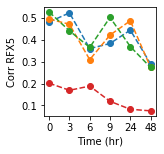

In [38]:
tf = 'RFX5'
plt.figure(figsize=(2,2))
plt.plot(moment_df.query('gene_1 == "{}"'.format(tf)).values[:, 2:].T, '--o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))

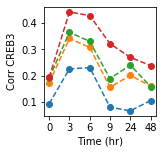

In [121]:
tf = 'CREB3'
plt.figure(figsize=(2,2))
plt.plot(moment_df.query('gene_1 == "{}"'.format(tf)).values[:, 2:].T, '--o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))
plt.savefig(fig_path + 'mhc_creb3_corr.pdf', bbox_inches='tight')

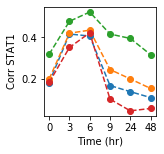

In [122]:
tf = 'STAT1'
plt.figure(figsize=(2,2))
plt.plot(moment_df.query('gene_1 == "{}"'.format(tf)).values[:, 2:].T, '--o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))
plt.savefig(fig_path + 'mhc_stat1_corr.pdf', bbox_inches='tight')

In [242]:
tf = 'CREB3'

In [243]:
moment_df.query('gene_1 == "{}"'.format(tf))

,gene_1,gene_2,time_0,time_3,time_6,time_9,time_24,time_48
828,CREB3,HLA-A,0.092283,0.225511,0.230557,0.079328,0.065209,0.104553
829,CREB3,HLA-B,0.172263,0.341903,0.307946,0.155191,0.201031,0.159479
830,CREB3,HLA-C,0.190355,0.365602,0.330579,0.188595,0.240382,0.157265
831,CREB3,B2M,0.193022,0.443010,0.429344,0.321969,0.269825,0.238096


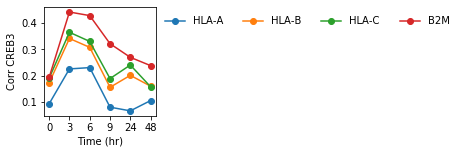

In [244]:
tf = 'CREB3'
plt.figure(figsize=(2,2))
plt.plot(moment_df.query('gene_1 == "{}"'.format(tf)).values[:, 2:].T, '-o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))
plt.legend(['HLA-A', 'HLA-B', 'HLA-C', 'B2M'], ncol=4, frameon=False, bbox_to_anchor=(1,1))

Text(0, 0.5, 'Corr STAT6')

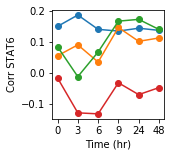

In [245]:
tf = 'STAT6'
plt.figure(figsize=(2,2))
plt.plot(moment_df.query('gene_1 == "{}"'.format(tf)).values[:, 2:].T, '-o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))

Text(0, 0.5, 'Corr JUND')

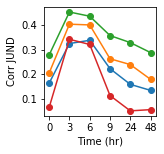

In [246]:
tf = 'JUND'
plt.figure(figsize=(2,2))
plt.plot(moment_df.query('gene_1 == "{}"'.format(tf)).values[:, 2:].T, '-o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))

Text(0, 0.5, 'Corr ETS2')

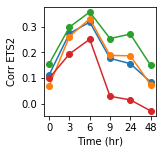

In [249]:
tf = 'ETS2'
plt.figure(figsize=(2,2))
plt.plot(moment_df.query('gene_1 == "{}"'.format(tf)).values[:, 2:].T, '-o')
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '3', '6', '9', '24', '48'])
plt.xlabel('Time (hr)'); plt.ylabel('Corr {}'.format(tf))

### ISG DC analysis - "positive" control

In [ ]:

cts = [['ciliated']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']


for ct in cts:
    for tp in tps:
        for stim in stims:
            
#             fname = '{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf)
#             if fname in done_files:
#                 continue
                            
            print('starting', ct, tp, stim)

            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin(['0',tp]), :].copy()
            time_converter={0:0, int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.9)
            
            tf_list = list(set(tfs) & set(adata_stim.var.index))
            
            gene_list = adata_stim.var.index.tolist()
            
            memento.compute_2d_moments(adata_stim, list(itertools.product(tf_list, ["HLA-A", "HLA-B", "HLA-C", "B2M"])))

            moment_df = memento.get_2d_moments(adata_stim, groupby='time_step')
            moment_df.to_csv('/data_volume/ifn_hbec/tf_test/moments_{}_{}_{}_mhc1.csv'.format('-'.join(ct), stim, tp), index=False)


            memento.ht_2d_moments( 
                adata_stim, 
                formula_like='1 + time_step',
                cov_column='time_step', 
                num_boot=10000, 
                verbose=1,
                num_cpus=13)

            if 'mv_regressor' in adata_stim.uns['memento']:
                del adata_stim.uns['memento']['mv_regressor']
            adata_stim.write('/data_volume/ifn_hbec/tf_test/{}_{}_{}_mhc1.h5ad'.format('-'.join(ct), stim, tp))

### CHIP analysis

In [36]:
tf = 'STAT1'
ct = ['ciliated']
stim = 'beta'

def get_2d_moments_ht(tf, ct, stim):
    
    adata_stim = adata.copy()[
        adata.obs.cell_type.isin(ct) & \
        adata.obs.time.isin(['0', '3']) & \
        adata.obs.stim.isin(['control', stim])].copy()
    time_converter={0:0, int('3'):1}
    adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

    memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.9)
    moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time_step')

    memento.compute_2d_moments(adata_stim, list(itertools.product([tf], adata_stim.var.index)))

    moment_df = memento.get_2d_moments(adata_stim, groupby='time_step')
    
    memento.ht_2d_moments( 
        adata_stim, 
        formula_like='1 + time_step',
        cov_column='time_step', 
        num_boot=10000, 
        verbose=1,
        num_cpus=13)
    
    ht_df = memento.get_2d_ht_result(adata_stim)
    
    return moment_df, ht_df

In [37]:
beta_df, beta_ht_df = get_2d_moments_ht(tf, ct, stim)

[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    9.3s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:   35.5s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:  1.3min
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:  2.4min
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:  3.6min
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:  5.2min
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  7.1min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  9.2min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed: 11.6min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed: 14.3min
[Parallel(n_jobs=13)]: Done 6024 tasks      | elapsed: 17.3min
[Parallel(n_jobs=13)]: Done 7174 tasks      | elapsed: 20.6min
[Parallel(n_jobs=13)]: Done 8424 tasks      | elapsed: 24.2min
[Parallel(n_jobs=13)]: Done 9641 out of 9641 | elapsed: 27.6min finished


In [39]:
beta_ht_df['isgf3'] = beta_ht_df.gene_2.apply(lambda x: 'in TSS' if x in isgf3_genes else 'rest')

In [40]:
beta_ht_df.head(5)

,gene_1,gene_2,corr_coef,corr_se,corr_pval,isgf3
0,STAT1,LINC01409,-0.232706,0.272895,0.398760,rest
1,STAT1,NOC2L,-0.026243,0.215634,0.892411,rest
2,STAT1,HES4,0.299789,0.093080,0.002000,rest
3,STAT1,ISG15,-0.064089,0.070980,0.360664,in TSS
4,STAT1,AGRN,-0.012531,0.166157,0.937506,rest


No handles with labels found to put in legend.


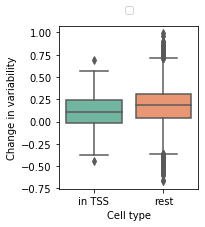

In [41]:
plt.figure(figsize=(2.5, 3))
sns.boxplot(x='isgf3', y='corr_coef', data=beta_ht_df.sort_values('isgf3'), palette='Set2')

plt.xlabel('Cell type'); plt.ylabel('Change in variability');
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.15))
# plt.ylim(-.8, 0.6)
# plt.savefig(fig_path + 'isgf3_vs_rest.pdf', bbox_inches='tight')

